## Sample Inference

Inference run of our model on 20 sample images from the `PubTables-1M` test dataset located in the `./sample_pubtables1m` directory.
The folder contains subfolders:
- `images` with images used for the inference
- `ocr` with ocr results from our custom internal ocr model
- `ocr_gt` with ocr results provided in the PubTables-1M dataset
- `test` with ground truth json files containing bounding boxes coordinates for tables, columns, rows, headers and extra_cells in the case of spanning cells

The below code:
- loads the model
- runs the inference on 20 sample images
- visualizes the output and saves it in the `./demo_results` directory
    - images with `.table.jpg` suffix contain the prediction of our model
    - other images contain the visualized ground truth and prediction for classes where some mistake was made
- calculates average precision and average recall metrics


In [4]:
import os
import sys
import json
import torch
import numpy as np
from torch.utils.data import DataLoader

from model_functions.transformer_tf_copy import TransformerEncoderTable
from train_data_preparation.coco_tables_dataset import CocoValidDataset
from train.table_extraction import collate_fn_pad, run_all_validations


if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

model_recognition = TransformerEncoderTable(num_clustering_heads=4, is_use_4_points=True,
                                            is_use_image_patches=True, use_content_emb=True)

if torch.cuda.is_available():
    model_recognition.cuda(0)
    # weights are in float16 precision
    model_recognition.half()

checkpoint_path_recognition = 'model_weights/table_recognition.pth'
checkpoint_recognition = torch.load(checkpoint_path_recognition, map_location=device)
model_recognition.load_state_dict(checkpoint_recognition, strict=False)
model_recognition = model_recognition.float()
model_recognition.eval()


num_clustering_heads = 4
class_map = {
    'table': 0,
    'table column': 1,
    'column': 1,
    'table row': 2,
    'row': 2,
    'table column header': 3,
    'table header': 3,
    'header': 3,
    'no object': 6
}

# path to our validation datasets
dataset_paths_validation = {
    './sample_pubtables1m': 1,
}
eval_set = 'test'

valid_dataset = CocoValidDataset(dataset_paths_validation,
                                 eval_set,
                                 class_map=class_map,
                                 num_clustering_heads=num_clustering_heads,
                                 ocr_labels_folder='ocr',
                                 is_use_4_points=True,
                                 is_use_image_patches=True,
                                 is_one_model='both',
                                 use_cell_pointers=True,
                                 is_augment_in_eval=False)

valid_loader = DataLoader(valid_dataset,
                          batch_size=1,
                          shuffle=False,
                          pin_memory=True,
                          num_workers=8,
                          drop_last=False,
                          collate_fn=collate_fn_pad)

output_dir = './demo_results'
os.makedirs(output_dir, exist_ok=True)

best_score = run_all_validations(model_recognition,
                                 valid_loader,
                                 output_dir,
                                 is_use_4_points=True,
                                 is_run_4_5_classes=False,
                                 is_debug_plot=True,
                                 is_augment_in_eval=False)

print('Best score:', best_score)
print('END')


d_model 256
is_sum_embeddings True
use_content_emb True
num_coords 8


/home/ec2-user/efs/marco/gpt4hana/venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Looking for jsons


100%|██████████| 1/1 [00:00<00:00, 1479.47it/s]


Looking for images


100%|██████████| 1/1 [00:00<00:00, 1642.25it/s]


Looking for OCR


100%|██████████| 50/50 [00:00<00:00, 105.90it/s]


creating index...
index created!


validation:   4%|▍         | 2/50 [00:00<00:15,  3.18it/s]

current accuracy 0.9972317840619752
For all (6) classes
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.945
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.972
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.940
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.824
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.918
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.974
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.476
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.851
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.959
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.833
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.

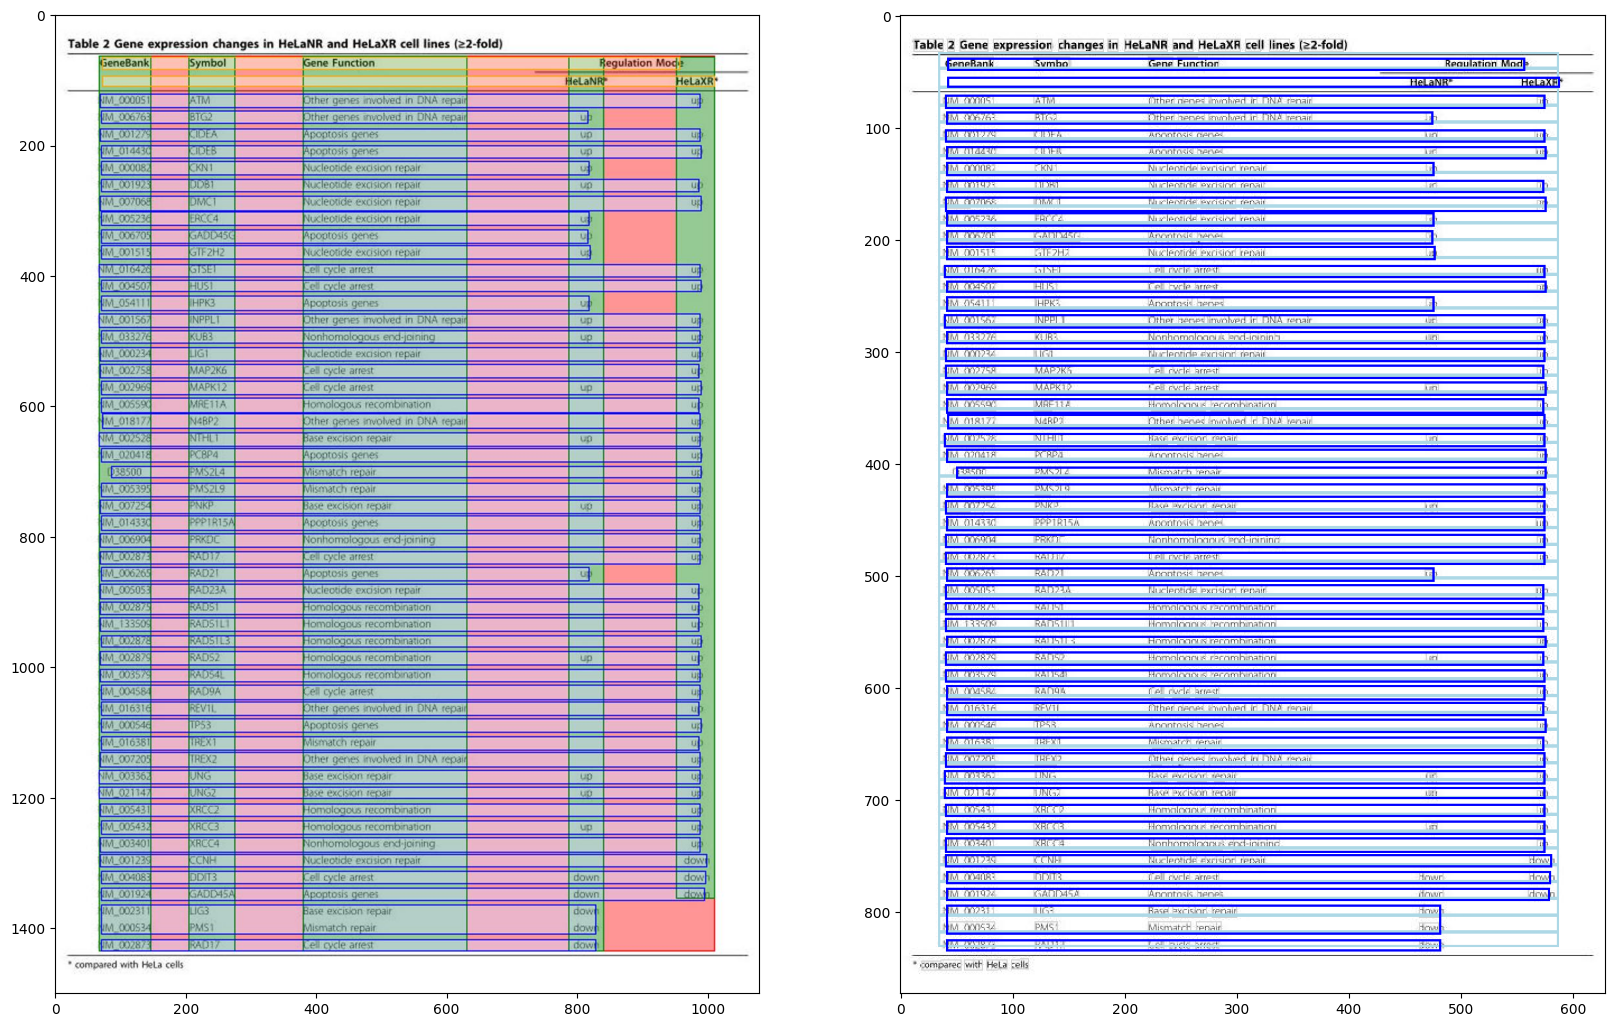

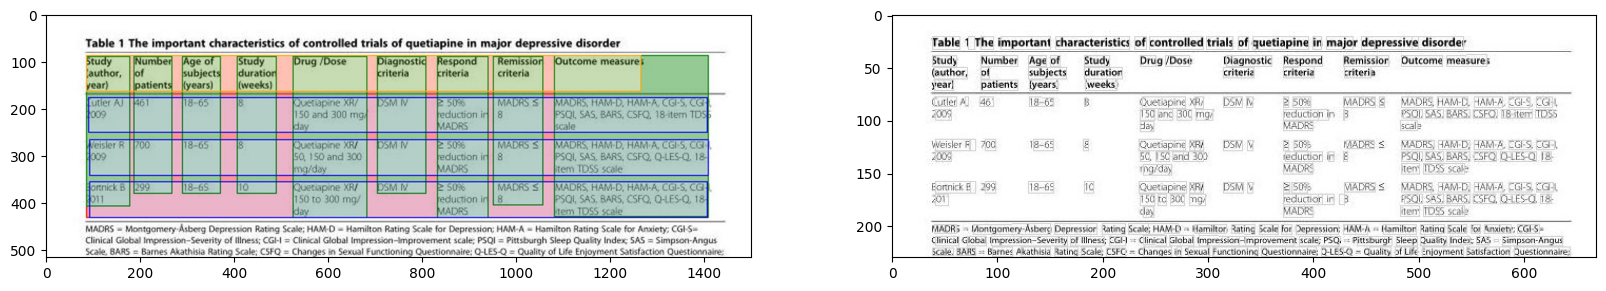

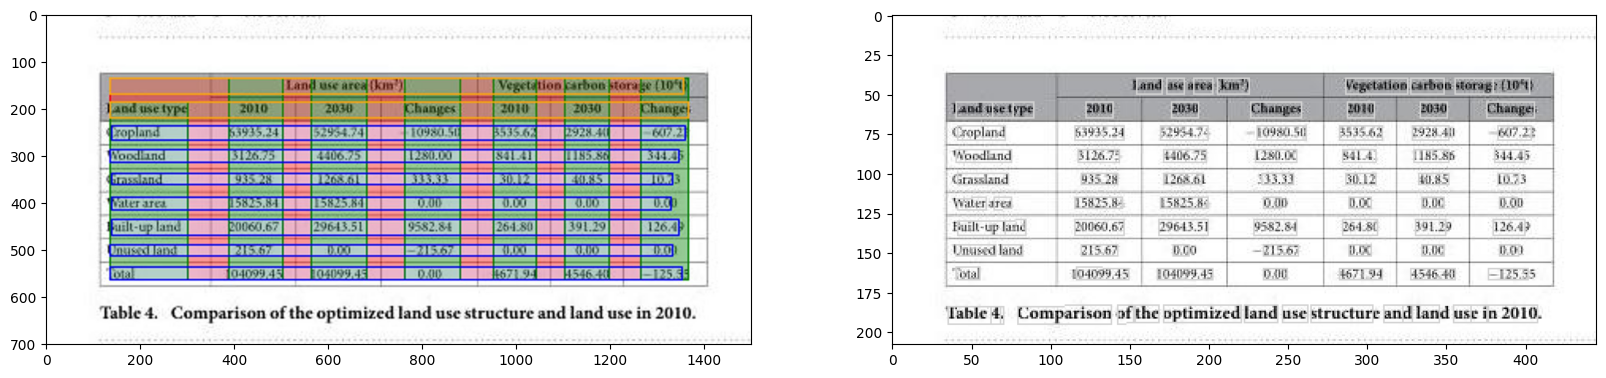

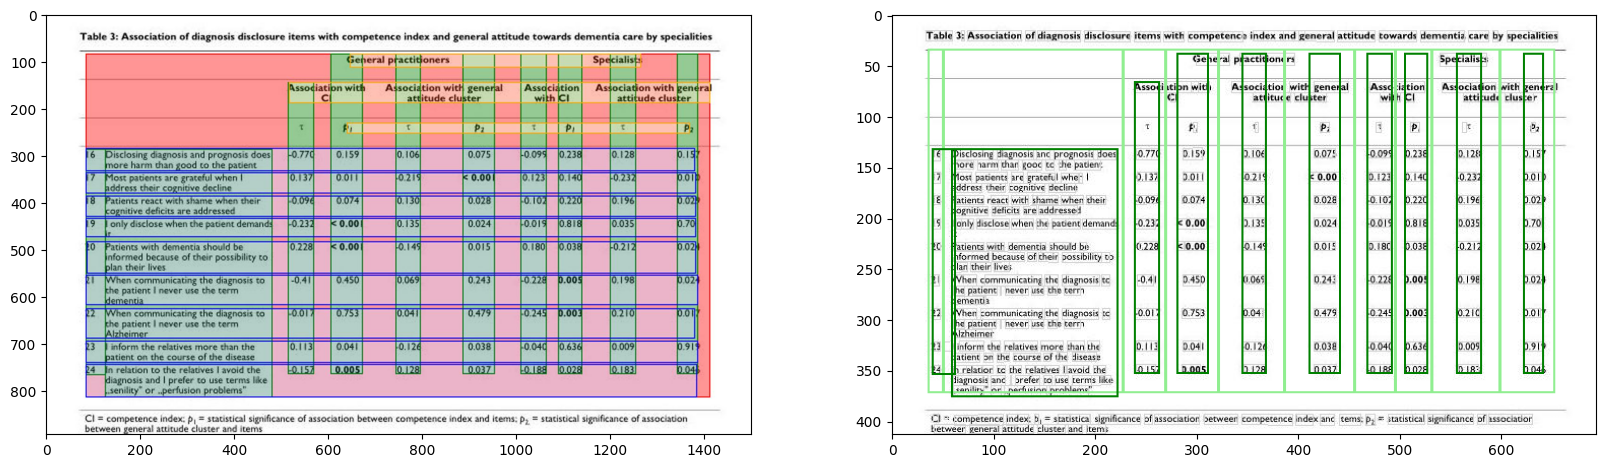

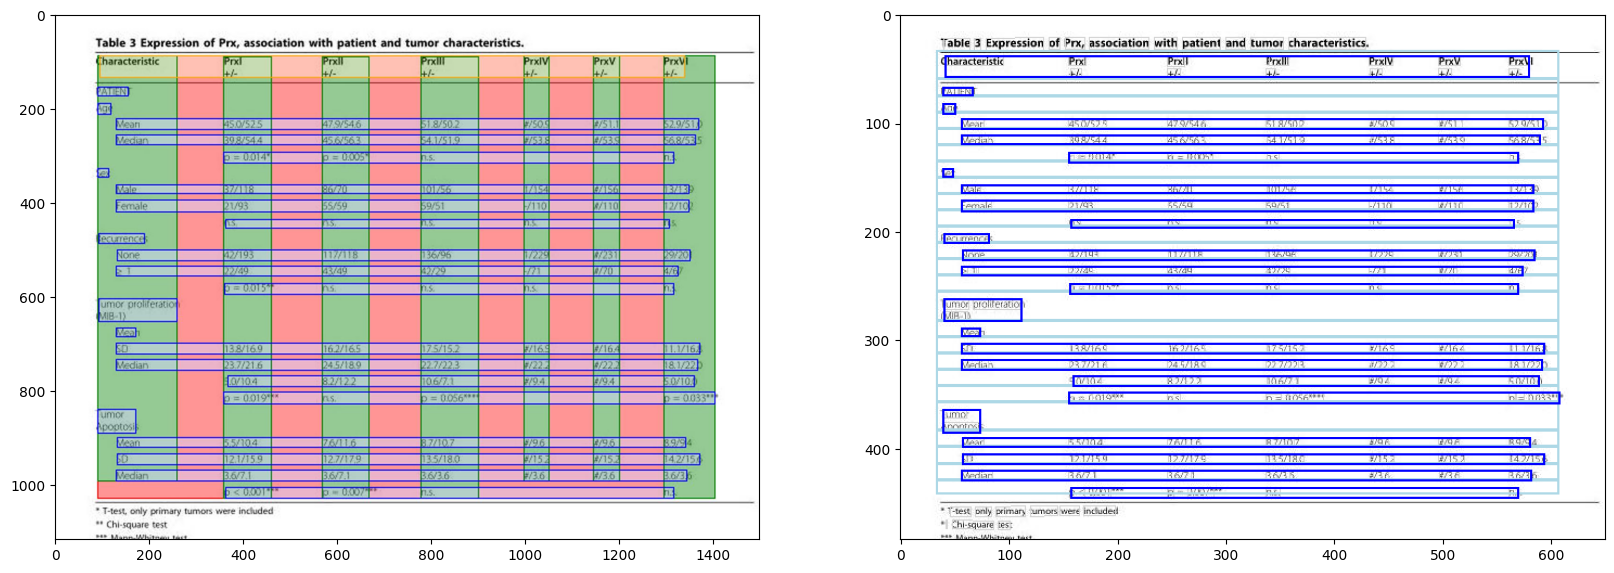

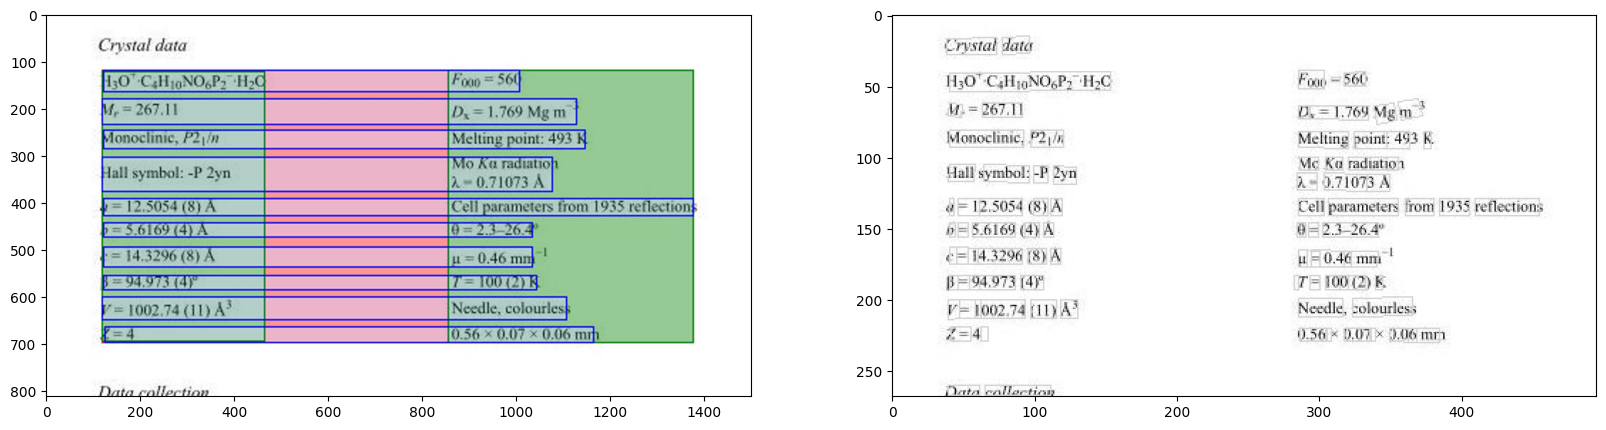

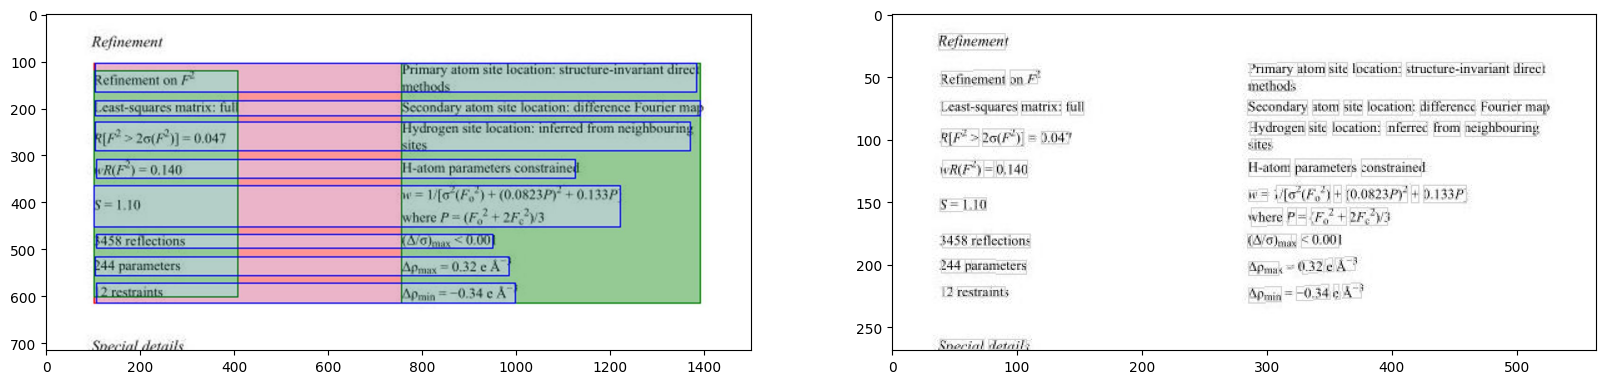

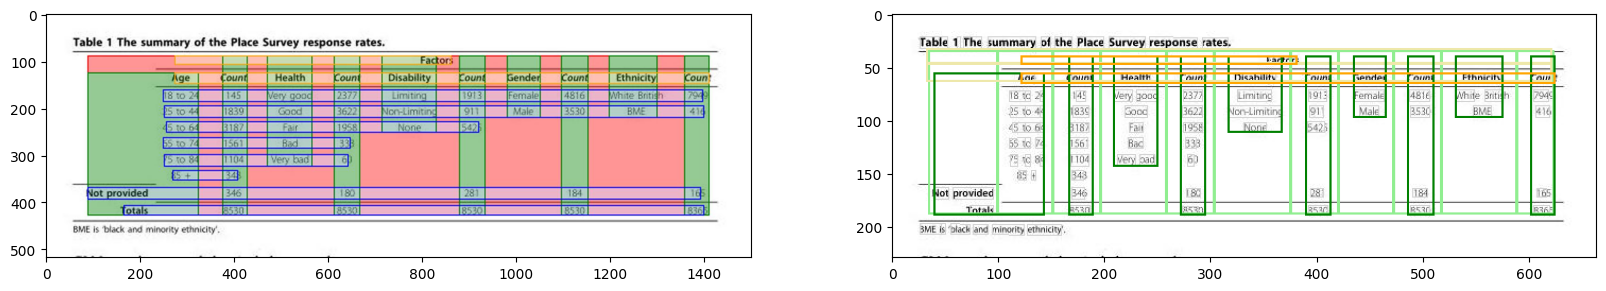

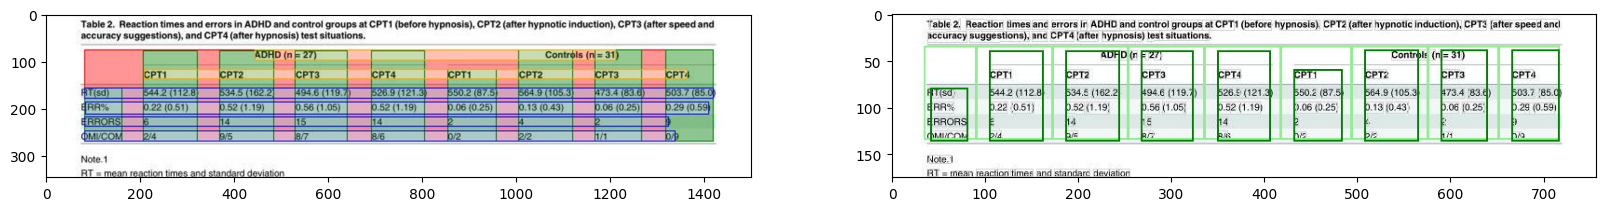

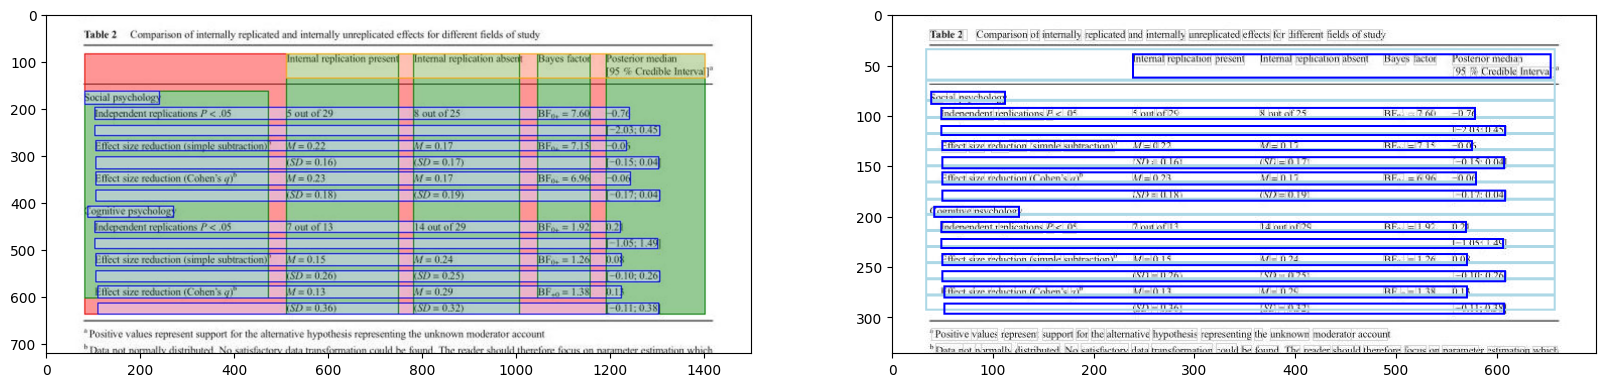

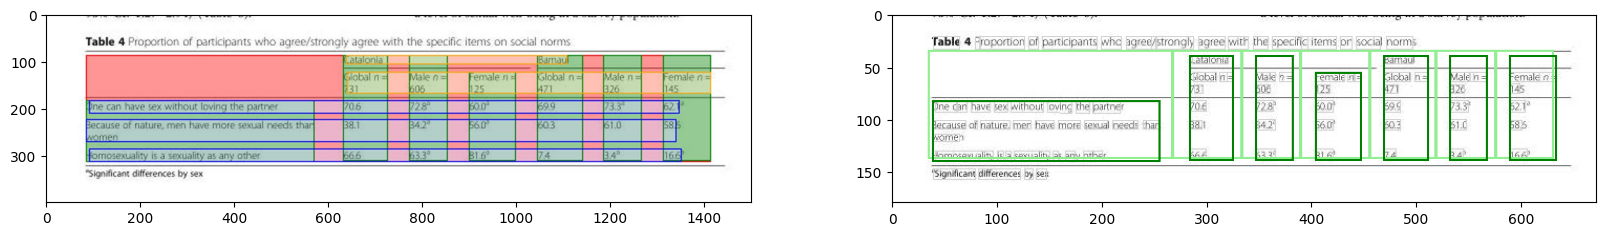

In [5]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = [20, 15]


files_to_show = [['PMC2838822_table_1.table.jpg', 'PMC2838822_table_1.png'],
                 ['PMC3549283_table_0.table.jpg', 'PMC3549283_table_0.png'],
                 ['PMC5109288_table_1.table.jpg', 'PMC5109288_table_1.png'],
                 ['PMC2289812_table_2.table.jpg', 'PMC2289812_table_2.png'],
                 ['PMC2858108_table_2.table.jpg', 'PMC2858108_table_2.png'],
                 ['PMC2960100_table_0.table.jpg', 'PMC2960100_table_0.png'],
                 ['PMC3050135_table_1.table.jpg', 'PMC3050135_table_1.png'],
                 ['PMC3155965_table_0.table.jpg', 'PMC3155965_table_0.png'],
                 ['PMC4427493_table_1.table.jpg', 'PMC4427493_table_1.png'],
                 ['PMC5050250_table_1.table.jpg', 'PMC5050250_table_1.png'],
                 ['PMC5789694_table_2.table.jpg', 'PMC5789694_table_2.png']]

for example in files_to_show:
    # read images
    img_vis = mpimg.imread(os.path.join('demo_results', example[0]))
    img_mistakes = mpimg.imread(os.path.join('demo_results', example[1]))

    # display images
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(img_vis)
    ax[1].imshow(img_mistakes)


### Show attention
Visualize predicted attention scores used for clustering.
Please, run first the previous cells in the notebook.

validation:  24%|██▍       | 12/50 [00:00<00:01, 35.01it/s]/tmp/ipykernel_27777/2856861260.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')
validation:  42%|████▏     | 21/50 [00:00<00:00, 37.44it/s]

(4, 212, 212)
(4, 83, 83)


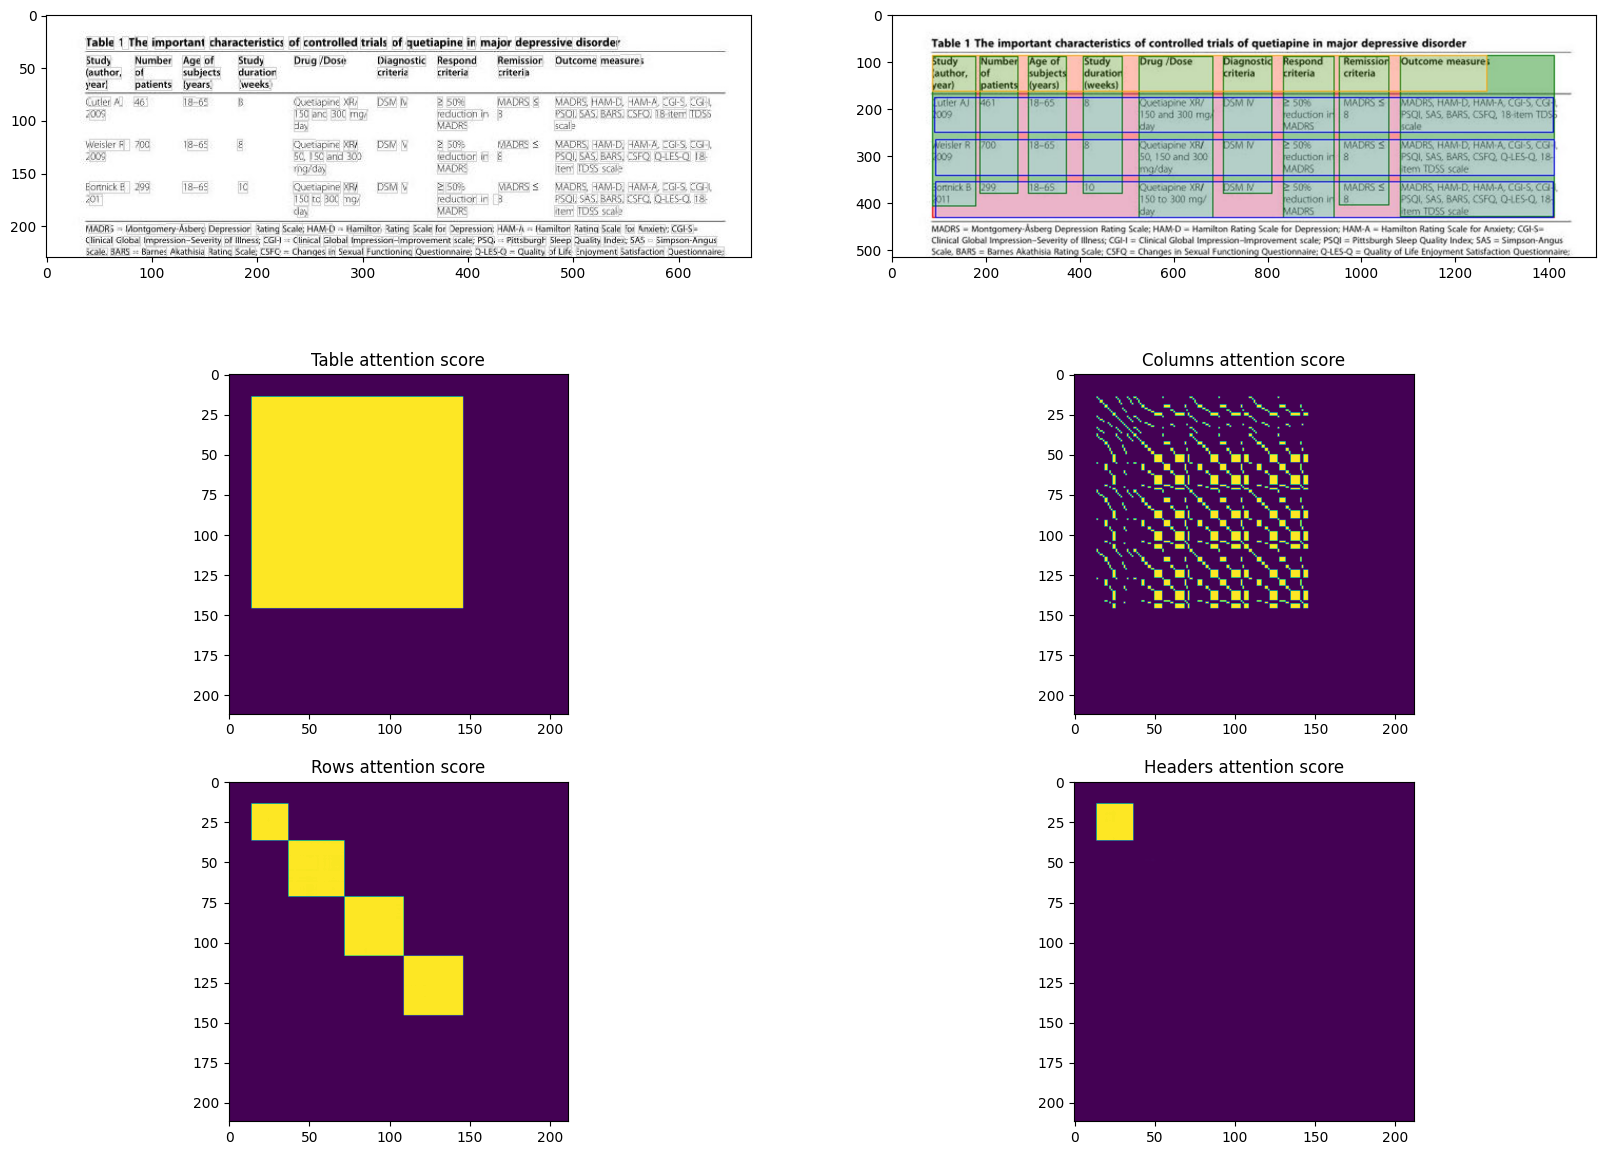

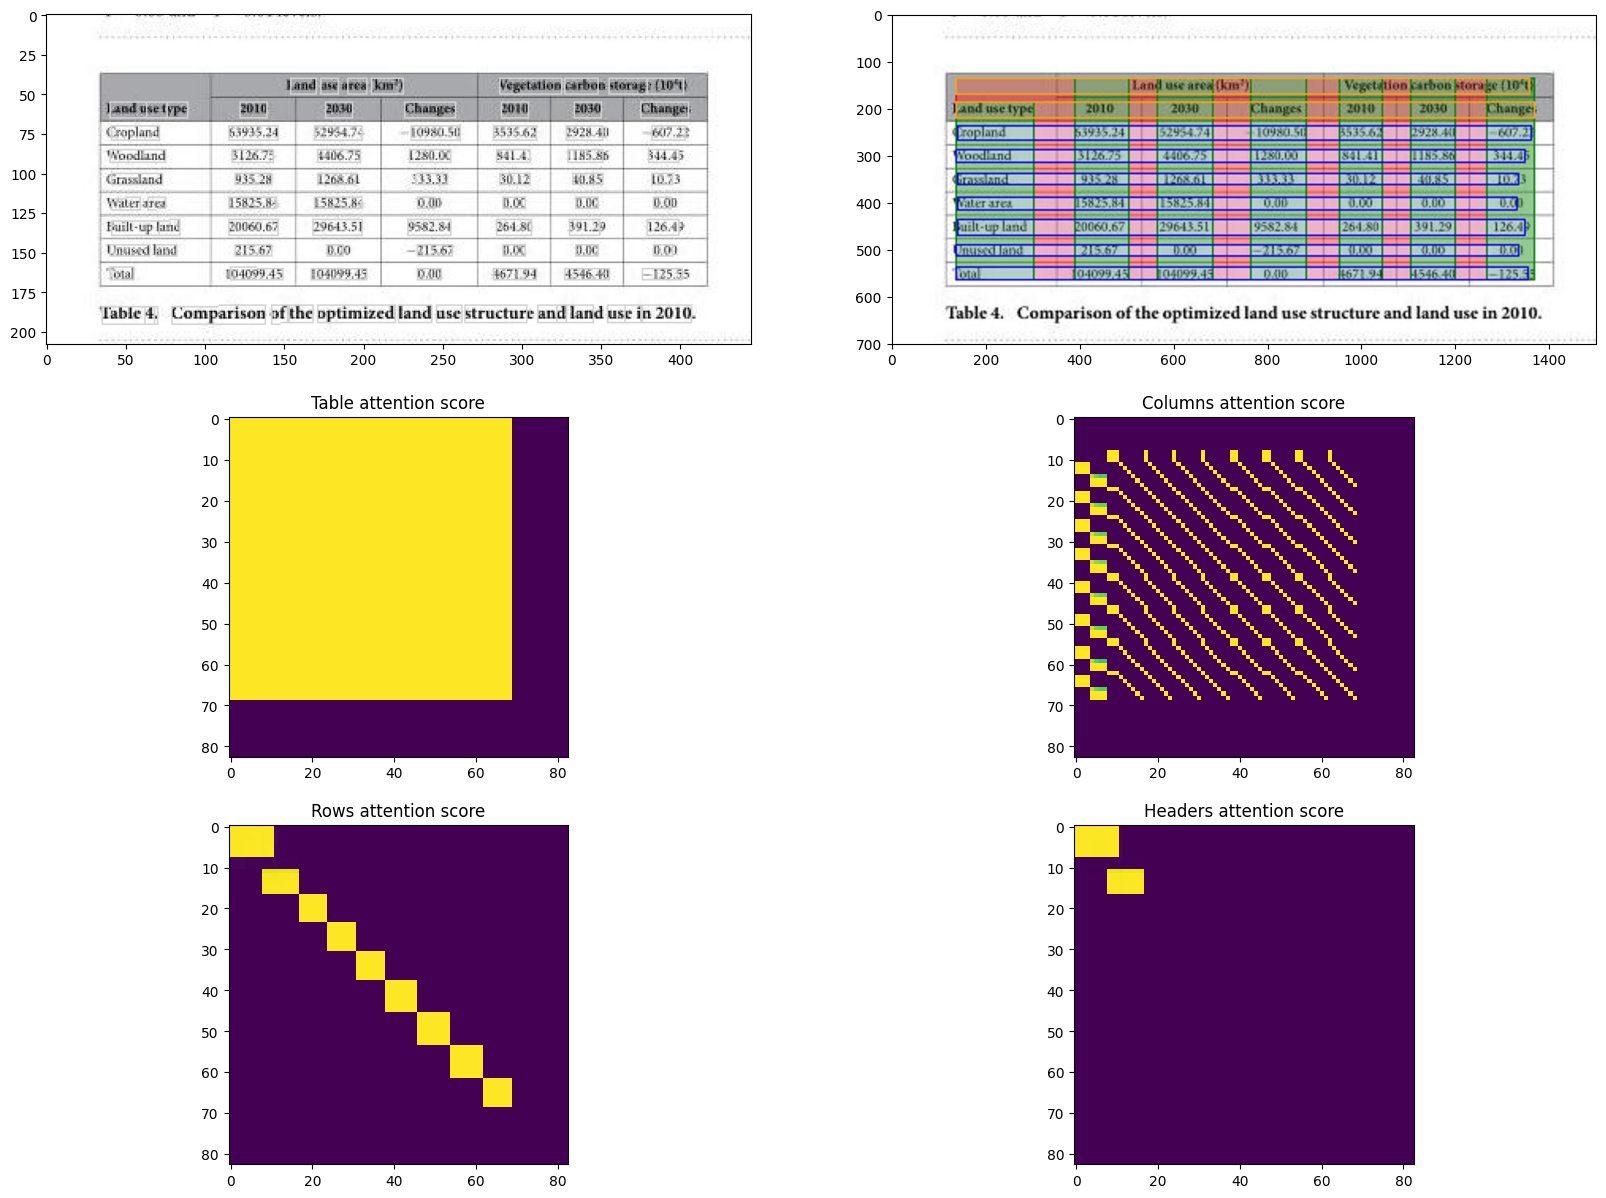

In [6]:
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib import rcParams
%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = [20, 15]

# loaded in the previous notebook cell
model = model_recognition


images_to_visualize = ['PMC3549283_table_0.jpg', 'PMC5109288_table_1.jpg']

for word_boxes, contents_idx, target, adjacency_matrices, _, mask, image_size, \
    img_patches, perspective_transform, shadow_mask, crop_size, header_mask in tqdm(valid_loader, leave=False, desc='validation'):
        if os.path.basename(target['img_path'][0]) not in images_to_visualize:
            continue

        assert word_boxes.size(0) == 1,\
            f'Only batch_size=1, got {word_boxes.size(0)} is supported in validation'

        word_boxes = word_boxes[mask > 0].to(device)
        if img_patches.numel():
            img_patches = img_patches[mask > 0].unsqueeze(0)
        img_patches = img_patches.to(device)
        contents_idx = contents_idx[mask > 0].to(device)

        preds = model(word_boxes.unsqueeze(0),
                      contents_idx.unsqueeze(0),
                      None,
                      img_patches)
        preds = torch.cat(preds).cpu() # <number_of_heads, num_words, num_words>
        preds = torch.sigmoid(preds)
        preds = preds.detach().numpy()
        print(preds.shape)

        img_vis = mpimg.imread(os.path.join('demo_results', os.path.basename(target['img_path'][0].replace('.jpg', '.png'))))
        img_with_predictions = mpimg.imread(os.path.join('demo_results', os.path.basename(target['img_path'][0].replace('.jpg', '.table.jpg'))))

        cmap = cm.get_cmap('viridis')
        fig, ax = plt.subplots(3,2)
        ax[0, 0].imshow(img_vis)
        ax[0, 1].imshow(img_with_predictions)
        ax[1, 0].imshow(preds[0], cmap=cmap)
        ax[1, 0].title.set_text('Table attention score')
        ax[1, 1].imshow(preds[1], cmap=cmap)
        ax[1, 1].title.set_text('Columns attention score')
        ax[2, 0].imshow(preds[2])
        ax[2, 0].title.set_text('Rows attention score')
        ax[2, 1].imshow(preds[3])
        ax[2, 1].title.set_text('Headers attention score')


### Sample Model Training

To run the sample training/finetuning with the same 20 images, please find the below code.
Assumes that the previous cells in this jupyter notebook were already run. 

In [6]:
from train_data_preparation.tables_dataset import TrainTablesDataset
from tqdm import trange, tqdm
from train.table_extraction import compute_cost


if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

model = model_recognition
print('Number of model parameters', sum(p.numel() for p in model.parameters() if p.requires_grad))

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model.train()
if torch.cuda.is_available():
    model.cuda(0)

# for the demo purposes, we use the same 20 sample images for finetuning
dataset_paths = {
    './sample_pubtables1m': 1,
}

train_dataset = TrainTablesDataset(dataset_paths,
                                   class_map=class_map,
                                   num_clustering_heads=num_clustering_heads,
                                   ocr_labels_folder='ocr',
                                   is_use_4_points=True,
                                   is_use_image_patches=True,
                                   is_one_model='both',
                                   use_cell_pointers=True)

train_loader = DataLoader(train_dataset,
                          batch_size=8,
                          shuffle=True,
                          pin_memory=True,
                          num_workers=8,
                          drop_last=True,
                          collate_fn=collate_fn_pad)


train_iterator = iter(train_loader)

EPOCHS = 3
STEPS_PER_EPOCH = 10
best_score = 0.0

for epoch in trange(EPOCHS):
    model.train()
    progress_bar = trange(STEPS_PER_EPOCH, leave=False, desc='Train')

    for _ in progress_bar:
        try:
            word_boxes, contents_idx, _, adjacency_matrices, _, mask, _, img_patches, _, shadow_mask, _, header_mask = next(
                train_iterator)
        except StopIteration:
            train_iterator = iter(train_loader)
            word_boxes, contents_idx, _, adjacency_matrices, _, mask, _, img_patches, _, shadow_mask, _, header_mask = next(
                train_iterator)

        word_boxes = word_boxes.to(device)
        img_patches = img_patches.to(device)
        contents_idx = contents_idx.to(device)
        mask = mask.to(device).float()
        shadow_mask = shadow_mask.to(device).float()
        header_mask = header_mask.to(device).float()
        adjacency_matrices = adjacency_matrices.to(device)

        preds_clustering = model(word_boxes, contents_idx, mask, img_patches)

        cost = compute_cost(preds_clustering, adjacency_matrices, mask, shadow_mask, header_mask)

        progress_bar.set_description(f'Train loss {cost:.6f}')
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        model.zero_grad()


Number of model parameters 15117192
Looking for jsons


100%|██████████| 1/1 [00:00<00:00, 1110.19it/s]


Looking for images


100%|██████████| 1/1 [00:00<00:00, 1260.69it/s]


Looking for OCR


100%|██████████| 3/3 [00:17<00:00,  5.81s/it]
